In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [307]:
import numpy as np
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from numba import njit
import cv2
from scipy.optimize import curve_fit

In [308]:
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight



def sersic(
    width,
    height,
    xc,
    yc,
    k,
    n,
    inclination=0,
    rotation=0,
    n_arms=0,
    winding=1,
    bulge_strength=1,
    Rc=30,
    direction=1,
):
    """
    Compute the Sersic galaxy centered at (xc, yc)
    """
    y, x = np.indices((width, height), dtype=float)
    x_rel = x - xc
    y_rel = y - yc

    # Transform to polar coordinates
    r = np.sqrt(x_rel**2 + y_rel**2)
    theta = np.arctan2(y_rel, x_rel) * direction

    # Calculate the bulge
    bulge = np.exp(-k * r ** (1 / n))

    # Add arms
    if n_arms > 0:
        arms = 1 + np.cos(n_arms * (theta - winding * np.log(r + 1e-6)))
    else:
        arms = 0

    # Add the arms and bulge together
    galaxy = bulge * bulge_strength + arms * np.exp(-((r / Rc) ** 2))

    # Flatten the image due to inclination
    scale_y = np.cos(inclination)
    M_incline = np.float32([[1, 0, 0], [0, scale_y, yc * (1 - scale_y)]])
    galaxy_inclined = cv2.warpAffine(
        galaxy, M_incline, (width, height), flags=cv2.INTER_CUBIC
    )

    # Rotate around (xc, yc)
    M_rot = cv2.getRotationMatrix2D((xc, yc), np.degrees(rotation), 1.0)
    galaxy_final = cv2.warpAffine(
        galaxy_inclined, M_rot, (width, height), flags=cv2.INTER_CUBIC
    )

    return galaxy_final


def moffat(
    height,
    width,
    m: float,
    a: float,
    n_spikes: int = 0,
    rotation: float = 0.0,
    spike_strength: float = 2.0,
    spike_width: float = 4.0,
    Rc: float = 10.0,
):
    """
    Calculate the PSF following moffat and add spikes if wanted
    """
    y, x = np.indices((height, width), dtype=float)
    xc, yc = width / 2, height / 2
    x_rel = x - xc
    y_rel = y - yc

    # Transform to polar coordinates
    r = np.sqrt(x_rel**2 + y_rel**2)
    theta = np.arctan2(y_rel, x_rel) + rotation

    # Calculate the center shape of the PSF
    center = (1 + (r / a) ** 2) ** (-m)

    # Calculate the spikes
    spikes = np.zeros_like(center)
    for i in range(n_spikes):
        angle = i * 2 * np.pi / n_spikes
        dist = np.abs(np.cos(theta - angle))
        spikes += np.exp(-((dist / spike_width) ** 2))

    # Add the spikes to the center
    moffat = center + spike_strength * spikes * np.exp(-((r / Rc) ** 2))
    return moffat / moffat.sum()

def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return image[y0:y1, x0:x1]


def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window


@njit
def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

# @njit(fastmath=True)
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"] * W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]

def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    weight_rescale /= np.sum(weight_rescale)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale


def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

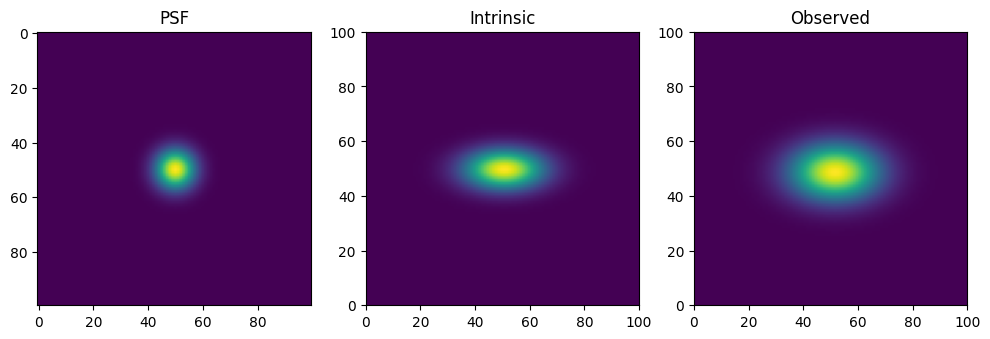

In [300]:
width = 100
height = 100
source_x_sigma = 10
source_y_sigma = 5
# Create PSF and Galaxy images
psf_sigma = 5
image_psf = gaussian_weight(height, width, height / 2, width / 2, psf_sigma, psf_sigma)
image_intrinsic = gaussian_weight(height, width, height / 2, width / 2, source_x_sigma, source_y_sigma) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf)
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [ ]:
def elliptical_gaussian(coords, A, x0, y0, sigma_x, sigma_y, theta):
    """
    2D elliptical Gaussian with rotation.
    
    coords : tuple of (x, y) flattened
    """
    x, y = coords
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    
    x_shift = x - x0
    y_shift = y - y0
    
    x_rot = cos_t * x_shift + sin_t * y_shift
    y_rot = -sin_t * x_shift + cos_t * y_shift
    
    g = A * np.exp(-0.5 * ((x_rot/sigma_x)**2 + (y_rot/sigma_y)**2))
    return g.ravel()

def deconv_gaussian_rms(image):
    """
    Fit an elliptical Gaussian to the deconvolved image
    and compute RMS error.
    
    Parameters
    ----------
    image : 2D array
        Deconvolved image
    
    Returns
    -------
    rms_error : float
        Root-mean-square difference relative to max of image
    fit_params : dict
        Fitted Gaussian parameters: A, x0, y0, sigma_x, sigma_y, theta
    """
    ny, nx = image.shape
    y, x = np.indices(image.shape)
    
    # Initial guess
    A0 = image.max()
    x0 = nx / 2
    y0 = ny / 2
    sigma_x = nx / 4
    sigma_y = ny / 4
    theta = 0.0
    p0 = (A0, x0, y0, sigma_x, sigma_y, theta)
    
    try:
        popt, _ = curve_fit(
            elliptical_gaussian,
            (x.ravel(), y.ravel()),
            image.ravel(),
            p0=p0,
            bounds=(
                [0, 0, 0, 0, 0, -np.pi/2],
                [np.inf, nx, ny, nx, ny, np.pi/2]
            )
        )
    except RuntimeError:
        # fit failed
        return np.inf, None
    
    # Reconstruct Gaussian
    fit_image = elliptical_gaussian((x, y), *popt).reshape(image.shape)
    
    # RMS error relative to max
    rms_error = np.sqrt(np.mean((image - fit_image)**2)) / image.max()
    
    fit_params = {
        "A": popt[0],
        "x0": popt[1],
        "y0": popt[2],
        "sigma_x": popt[3],
        "sigma_y": popt[4],
        "theta": popt[5]
    }
    
    return rms_error, fit_params


The aperture flux measured using the intrinsic image and weight function : 0.696865
1.0 0.9999999999999997
The aperture flux using the observed image and rescaled weight function : 0.695149


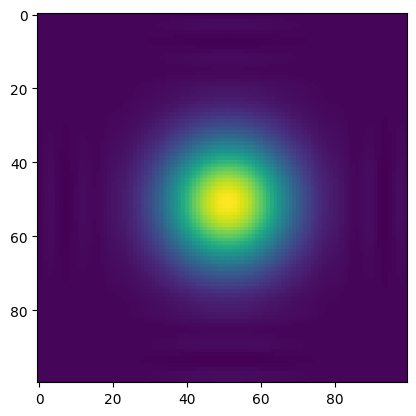

RMS error: 0.004224592943005027
Deconvolution is very Gaussian-like


In [305]:
# Define weight function
weight_size = 13
weight = gaussian_weight(height, width, height / 2, width / 2, weight_size, weight_size)
k_c = min(1/weight_size, np.pi/width, np.pi/2)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')
noise = np.random.normal(0, .1, size=image.shape)
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-6)
# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, weight_new = calculate_gaap_flux(image + noise, cache, weight, [(height / 2, width / 2)])

print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')
plt.imshow(weight_new)
plt.show()
rms, params = deconv_gaussian_rms(weight_new)
print("RMS error:", rms)

if rms < 0.01:
    print("Deconvolution is very Gaussian-like")
else:
    print("Significant deviation from Gaussian")

In [310]:
def find_deconvolution(weight, psf, K=1e-6):
    """
    Find the deconvolved weight function using Wiener deconvolution.
    """
    height, width = weight.shape
    K /= 10
    rms = np.inf
    while rms > 0.01 and K < 1e-2:
        K *= 10
        psf_cache = prepare_wiener_psf(psf, [height, width], K=K)
        weight_deconv = wiener_deconvolution_fast(weight, psf_cache)
        weight_deconv /= np.sum(weight_deconv)
        rms, _ = deconv_gaussian_rms(weight_deconv)
    return weight_deconv, K

def calculate_gaap_flux(image, psf, weight, centers, K=1e-15):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale, best_K = find_deconvolution(weight, psf, K=K)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0   ]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale, best_K

The aperture flux measured using the intrinsic image and weight function : 1.747375
The aperture flux using the observed image and rescaled weight function : 1.756101


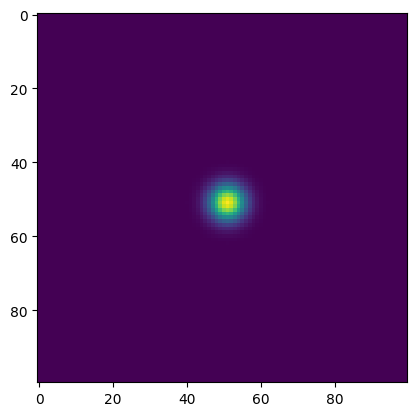

1e-15


In [ ]:
# Define weight function
weight_size = 6
weight = gaussian_weight(height, width, height / 2, width / 2, weight_size, weight_size)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')
noise = np.random.normal(0, .1, size=image.shape)
# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, weight_new, best_K = calculate_gaap_flux(image + noise, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')
plt.imshow(weight_new)
plt.show()
print(best_K)